In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect
from sqlalchemy import distinct

In [5]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [8]:
#Use inspector to inspect database
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
#Columns in Measurement Table
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#Columns in station Table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Get latest date in the data.As it is in string format, convert to date format for using in date calc
max_date_str=session.query(func.max(Measurement.date))[0][0]

max_date=dt.date(int(max_date_str[0:4]),int(max_date_str[5:7]),int(max_date_str[8:10]))

#start date: 12 months prior to max date
start_date=max_date-dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores for last 12 months
sel=[Measurement.date,Measurement.prcp]

precipitation_data = session.query(*sel).\
                     filter(Measurement.date>=start_date).\
                     order_by(Measurement.date).all()

#Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(precipitation_data,columns=['date','precipitation'])

precipitation_df.dropna(inplace=True)

precipitation_df.set_index('date',inplace=True)

precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


Text(0.5, 0, 'Date')

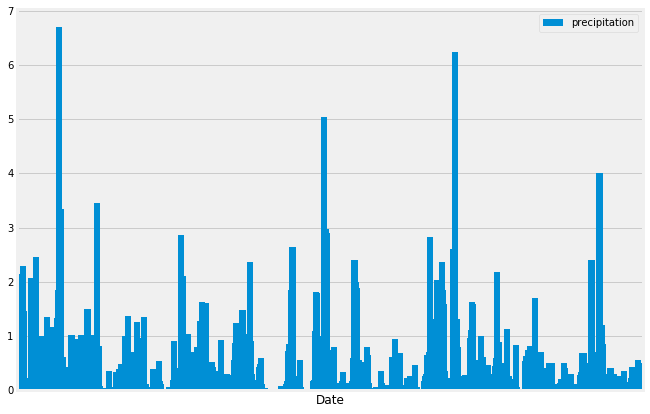

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
precip_plot=precipitation_df.plot.bar(figsize=(10,7),width=20,capstyle='round')

plt.xticks([])

plt.xlabel('Date')

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
sel=[func.count(distinct(Station.name))]
cnt_stations=session.query(*sel).first()
cnt_stations

(9)

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

sel=[Measurement.station,func.count(Measurement.station)]

active_stations=session.query(*sel).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

sel=[func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]

temp_USC00519281=session.query(*sel).\
                filter(Measurement.station=='USC00519281').\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).first()

temp_USC00519281

(54.0, 85.0, 71.66378066378067)

In [18]:
# Choose the station with the highest number of temperature observations.

sel=[Measurement.station]

temp_maxobs_station=session.query(*sel).\
                    filter(Measurement.tobs != None).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).first()[0]


# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_data = session.query(Measurement.date,Measurement.tobs).\
                          filter(Measurement.date>start_date).\
                          filter(Measurement.station==temp_maxobs_station).\
                          order_by(Measurement.date).all()

temp_data_df=pd.DataFrame(temp_data)

temp_data_df.head()

,date,tobs
0,2016-08-24,77.0
1,2016-08-25,80.0
2,2016-08-26,80.0
3,2016-08-27,75.0
4,2016-08-28,73.0


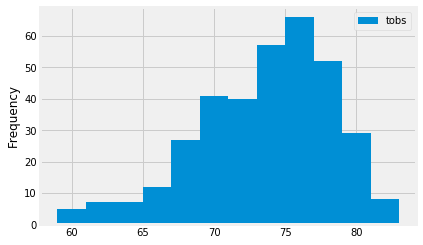

In [19]:
# Plot above results in histogram
temp_data_df.plot.hist(temp_data_df['tobs'],bins=12)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temps=list(calc_temps('2016-12-01', '2016-12-10')[0])
temps

[67.0, 71.29230769230769, 77.0]

Text(0, 0.5, 'Temp(F)')

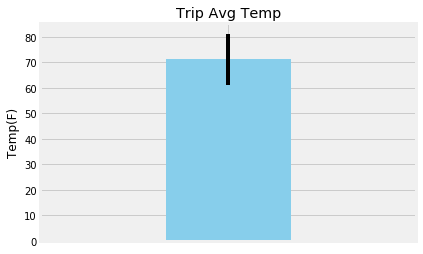

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


avg_temp=temps[1]
min_temp=temps[0]
max_temp=temps[2]

yerror=max_temp-min_temp

plt.bar(1.5,avg_temp,yerr=yerror,color='skyblue',width=1,tick_label='')
plt.xlim(0,3)
plt.title('Trip Avg Temp')
plt.ylabel('Temp(F)')

In [25]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date='2016-12-01'
end_date='2016-12-10'

sel=[Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]

rain_data = session.query(*sel).\
            filter(Measurement.date>start_date).\
            filter(Measurement.date<end_date).\
            filter(Measurement.station==Station.station).\
            group_by(Station.station).\
            order_by(func.sum(Measurement.prcp).desc()).all()

rain_df=pd.DataFrame(rain_data,columns=['Station','Station_name','Latitude','Longitude','Elevation','Total_rainfall'])

rain_df.head()

,Station,Station_name,Latitude,Longitude,Elevation,Total_rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,5.27
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.88
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,1.34
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.14
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.06
